# This code will perform data exploration on the dataset of ACLforces. But with normalized data now

In [101]:
import os
cwd = os.getcwd()
import seaborn as sns
import pandas as pd
import numpy as np
from opensim_utils_g import readMotionFile
import matplotlib.pyplot as plt
import perform_opensim_analyses_ACL
import AssignPropertiesCustomLigament
import scipy as sp
import scipy.interpolate


In [2]:
subjects = pd.DataFrame(['Ahelaos','Amanda','Celine','CharlotteH','CharlotteV','Esther','Filip',\
           'Franceska','Guido','Jeroen'])
age = pd.DataFrame([22,21,22,21,21,22,22,25,24,22])
BW = pd.DataFrame([74.0061,57.0846,57.7982,59.5311,54.6381,59.633,86.5443,58.2059,64.3221,72.0163])
data = pd.concat((subjects,age,BW),axis=1)
columns=['Names','Age','Body weight']
data.columns=columns
length = len(subjects)

In [3]:
length

10

In [8]:
columns=['Names','Age','BodyWeight']
data.columns=columns
data['BodyWeight'].std()

10.098664948183332

In [5]:
%load_ext autoreload
%autoreload 1
%aimport opensim_utils_g
%aimport perform_opensim_analyses_ACL
%matplotlib inline

In [6]:
#for i in range(0,1):
#    name = subjects[i]
#    m = cwd+'/Data/'+name+'/'+name+'_2.osim'
#    AssignPropertiesCustomLigament.change_properies(m,cwd+'/Data/swing_model.osim')
                                                            

In [7]:
#for i in range(0,length):
#    name = subjects[i]
#    model = cwd+'/Data/'+name+'/'+name+'_2CL.osim' 
#    perform_opensim_analyses_ACL.Opensim_Analysis(model)

In [11]:
i=0
kg = data.BodyWeight[i]
kg
kg_N = kg*9.81
kg_N

725.9998410000001

## Gather all data in one matrix. Different columns will be moments and rows will be acl_r (a and p) from every subject.

In [257]:
subjects = ['Ahelaos','Amanda','Celine','CharlotteH','CharlotteV','Esther','Filip',\
           'Franceska','Guido','Jeroen']
array_subj = []
for i in range(0,length):
    acl_r=[]
    joint_mom=[]
    acl_jm_kcf=[]
    array_trials=[]
    kcf = []
    name = subjects[i]
    results_dir = cwd+'/Data/'+name+'/Results'
    subj_dir = os.path.dirname(results_dir)
    kg = data.BodyWeight[i]
    kg_N = kg*9.81
    """ACL data"""
    for k in range(1,4):
        events_file = pd.read_excel(subj_dir+'/'+name+'_HDR_'+str(k)+'_Events.xls')
        init_time = events_file.InitialContactTime.iloc[0]
        final_time = events_file.TimeLowestCOMX.iloc[1]
        """Load kinematics"""
        ik_header, ik_labels, ik_data = readMotionFile(results_dir+'/HDR_'+str(k)+'_IK.mot')
        ik_d = np.array(ik_data)
        time = ik_d[:,0]
        timeList = time.tolist()
        idx3 = timeList.index(init_time)
        idx4 = timeList.index(final_time)
        array3 = ik_d[idx3:idx4+1,31:34]#lumbar
        array7 = ik_d[idx3:idx4+1,7:11]
        array5 = ik_d[idx3:idx4+1,13]*-1#anterior-posterior
        array5 = array5.reshape(len(array5),1)
        array4 = ik_d[idx3:idx4+1,16]
        array4 = array4.reshape(len(array4),1)
        joint_ang = np.concatenate((array3,array7,array5,array4),axis=1)
        """Load the acl forces"""
        so_header, so_labels, so_data = readMotionFile(results_dir+'/'+name+'_2CL_HDR_'+str(k)+'_StaticOptimization_force.sto')
        idx1 = so_labels.index('aACL_R')
        idx2 = so_labels.index('pACL_R')
        aACL_R_data = np.array([row[idx1] for row in so_data])
        pACL_R_data = np.array([row[idx2] for row in so_data])
        acl_r = (aACL_R_data+pACL_R_data)/kg_N
        acl_r = acl_r.reshape(len(acl_r),1)
        """Load the joint moments"""
        id_header, id_labels, id_data = readMotionFile(results_dir+'/HDR_'+str(k)+'_ID.sto')
        id_d = np.array(id_data/kg)
        array1 = id_d[:,1:4]
        array2 = id_d[:,7:13]
        array6 = id_d[:,16:19]
        joint_mom= np.concatenate((array1,array2,array6),axis=1)
        """Load the knee reaction forces"""
        jra_header, jra_labels, jra_data = readMotionFile(results_dir+'/'+name+'_2CL_HDR_'+str(k)+'_JointReaction_ReactionLoads.sto')
        j_data = np.array(jra_data/kg_N)
        kcf = j_data[:,19:22]
        """Concatenate the acl forces array with the joint moments array"""
        acl_jm_kcf_ja = np.concatenate((acl_r,joint_mom,kcf,joint_ang),axis=1)
        """Create the complete array for all three trials"""
        if k==1:
            array_trials = acl_jm_kcf_ja
        else:
            array_trials = np.concatenate((array_trials,acl_jm_kcf_ja),axis=0)
    """Create the array for all subjects"""
    if i==0:
        array_subj = array_trials
    else:
        array_subj = np.concatenate((array_subj,array_trials),axis=0)


In [258]:
"""Create the labels and the complete dataframe"""
str1 = id_labels[1:4]
str1.insert(0,'acl_r')
lb = str1+id_labels[7:13]+id_labels[16:19]+['KCF_X','KCF_Y','KCF_Z']+ik_labels[31:34]+ik_labels[7:11]+[ik_labels[13]]+[ik_labels[16]]
df = pd.DataFrame(array_subj,columns = lb)
df.shape

(603, 25)

In [374]:
df['acl_r'].std()

0.12928770807306877

## Pearson correlation heatmap

In [260]:
corr_matrix_pearson=df.corr()
corr_matrix_spearman = df.corr(method='spearman')

In [372]:
#plt.figure(figsize=(18,16))
#sns.heatmap(corr_matrix_pearson,annot=True, cmap='PuOr')

In [262]:
#Correlation with output variable
cor_target = (corr_matrix_pearson["acl_r"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.6]
relevant_features

acl_r                     1.000000
knee_rotation_r_moment    0.650338
knee_angle_r              0.702205
Name: acl_r, dtype: float64

## Spearman correlation heatmap

In [371]:
#plt.figure(figsize=(18,16))
#sns.heatmap(corr_matrix_spearman,annot=True, cmap='PuOr')

# Further data exploration

### Linear regression

In [265]:
import statsmodels.api as sm

In [266]:
y = df['acl_r']

In [267]:
X = df.drop(['acl_r'],axis=1)

In [268]:
## Without a constant

import statsmodels.api as sm

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
#model.summary()

### Now we add an intercept

In [269]:
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
#model.summary()

## Now we employ a random forest algorithm to find the most important feature

In [392]:
from sklearn.cross_validation  import train_test_split

In [393]:
df.shape

(603, 25)

In [394]:
y = df['acl_r']

In [395]:
X = df.drop(['acl_r'],axis=1)#feature list
X.head()

,pelvis_tilt_moment,pelvis_list_moment,pelvis_rotation_moment,hip_flexion_r_moment,hip_adduction_r_moment,hip_rotation_r_moment,knee_angle_r_moment,knee_adduction_r_moment,knee_rotation_r_moment,ankle_angle_r_moment,...,KCF_Z,lumbar_extension,lumbar_bending,lumbar_rotation,hip_flexion_r,hip_adduction_r,hip_rotation_r,knee_angle_r,knee_anterior_posterior_r,ankle_angle_r
0,0.326485,-1.059244,0.159688,-27.819817,-42.829184,7.658052,69.762360,-21.615481,-1.006198,-1.878002,...,0.160589,-31.935843,-1.230907,-1.835865,13.159312,-8.171138,-9.369979,-19.646183,0.005266,-20.421358
1,-4.081214,-2.427259,-0.714511,-31.528434,-40.763775,8.709536,75.589431,-24.373761,-3.378937,-1.620569,...,0.367139,-32.488091,-0.342815,-1.183096,14.515924,-7.119263,-12.309192,-26.125428,-0.009679,-14.601721
2,-0.736292,1.097312,-0.226119,-25.420553,-31.810554,7.941919,81.348481,-21.847014,-5.355983,-1.518817,...,-0.284287,-32.121132,-0.340441,0.042969,19.671435,-6.774063,-9.316728,-34.876403,-0.013694,-12.316137
3,-0.584083,-0.464303,-0.110406,-23.584883,-29.505147,8.482252,84.581835,-22.532940,-7.544397,-1.404110,...,-0.102269,-32.219167,0.838950,1.855638,23.224491,-3.648728,-4.727208,-41.246277,-0.013803,-10.924234
4,0.349453,-0.760231,0.078806,-20.759117,-26.325280,8.874721,86.713695,-22.470463,-9.554635,-1.315877,...,-0.059035,-32.622028,2.553274,2.735696,25.154920,-0.878219,-3.833469,-45.746437,-0.012490,-8.570429


In [396]:
#np.random.seed(seed = 42)
#X['random'] = np.random.random(size = len(X))

In [397]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [398]:
X_train.shape

(452, 24)

In [399]:
from sklearn.ensemble import RandomForestRegressor

In [400]:
rf = RandomForestRegressor(n_estimators = 1000,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)

In [401]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [402]:
rf.score(X_test, y_test)

0.8464638128418667

In [403]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_test, y_test)))

R^2 Training Score: 0.98 
OOB Score: 0.85 
R^2 Validation Score: 0.85


## Well, there is some overfitting in the model, as it performs worse on OOB sample and worse on the validation set

In [404]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_list = list(X.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
print[('Variable: {:20} Importance: {} '.format(*pair)) for pair in feature_importances]

['Variable: knee_rotation_r_moment Importance: 0.61 ', 'Variable: knee_angle_r         Importance: 0.13 ', 'Variable: hip_adduction_r_moment Importance: 0.06 ', 'Variable: knee_angle_r_moment  Importance: 0.02 ', 'Variable: ankle_angle_r_moment Importance: 0.02 ', 'Variable: lumbar_bending       Importance: 0.02 ', 'Variable: knee_anterior_posterior_r Importance: 0.02 ', 'Variable: hip_flexion_r_moment Importance: 0.01 ', 'Variable: hip_rotation_r_moment Importance: 0.01 ', 'Variable: knee_adduction_r_moment Importance: 0.01 ', 'Variable: subtalar_angle_r_moment Importance: 0.01 ', 'Variable: KCF_X                Importance: 0.01 ', 'Variable: KCF_Z                Importance: 0.01 ', 'Variable: lumbar_extension     Importance: 0.01 ', 'Variable: lumbar_rotation      Importance: 0.01 ', 'Variable: hip_flexion_r        Importance: 0.01 ', 'Variable: hip_rotation_r       Importance: 0.01 ', 'Variable: pelvis_tilt_moment   Importance: 0.0 ', 'Variable: pelvis_list_moment   Importance: 0.0 

In [450]:
import_df = pd.concat([pd.Series(v, name=k) for k, v in feature_importances], axis=1)
import_df_nonzero = import_df.loc[:, (import_df != 0).all()]
import_df_nonzero.shape[1]

17

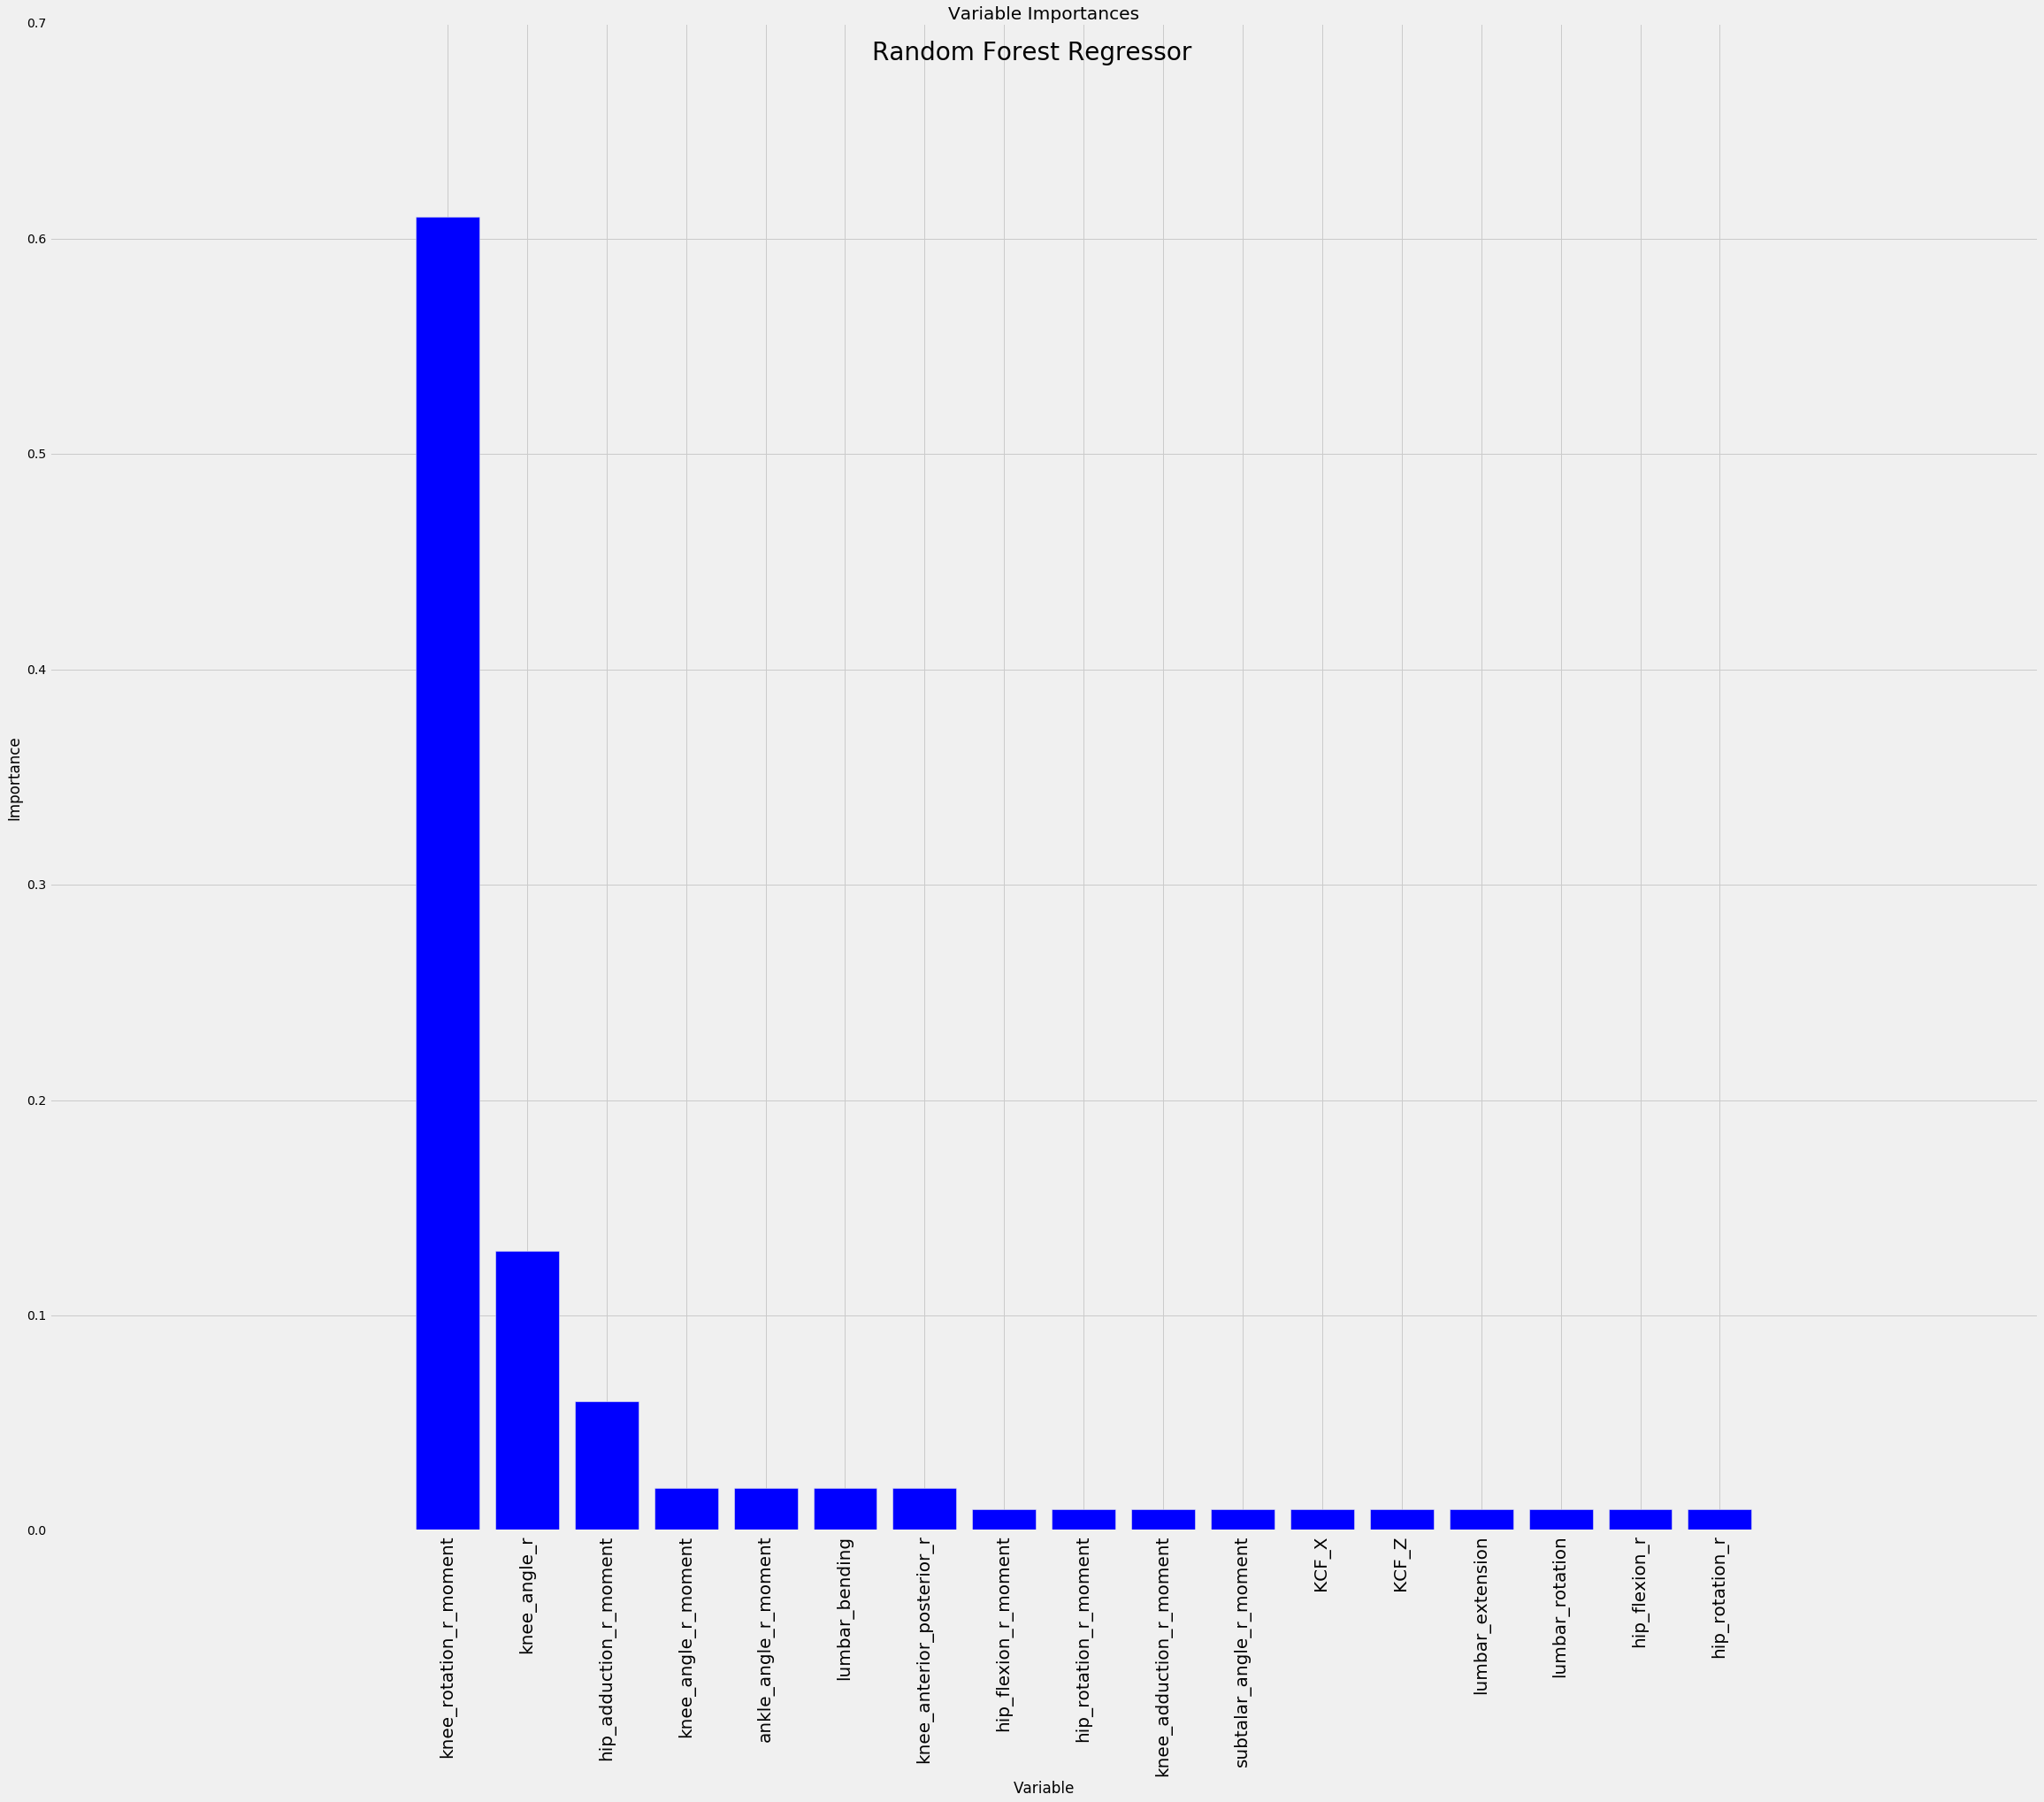

In [453]:
plt.figure(figsize=(32,28))
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(import_df_nonzero.shape[1]))
# Make a bar chart
plt.bar(x_values, import_df_nonzero.iloc[0], orientation = 'vertical',align="center")
# Tick labels for x axis
plt.xticks(x_values, import_df_nonzero.columns, rotation='vertical',fontsize=20)
plt.tight_layout()
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.suptitle('Random Forest Regressor',fontsize=28);plt.title('Variable Importances')
plt.savefig('Random Forcest Regressor.jpg',dpi=100)

## Now we re-run the analysis with the first 6 most important features

In [360]:
low_features = []
for i in range(8,len(feature_importances)):
    low_features.append(feature_importances[i][0])


In [361]:
low_features.append('acl_r')

In [362]:
X = df.drop((low_features),axis=1)

In [363]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [364]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_test, y_test)))

R^2 Training Score: 0.98 
OOB Score: 0.86 
R^2 Validation Score: 0.84


In [365]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_list = list(X.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
print[('Variable: {:20} Importance: {} '.format(*pair)) for pair in feature_importances]

['Variable: knee_rotation_r_moment Importance: 0.62 ', 'Variable: knee_angle_r         Importance: 0.15 ', 'Variable: hip_adduction_r_moment Importance: 0.07 ', 'Variable: knee_angle_r_moment  Importance: 0.04 ', 'Variable: ankle_angle_r_moment Importance: 0.04 ', 'Variable: lumbar_bending       Importance: 0.04 ', 'Variable: hip_flexion_r_moment Importance: 0.03 ', 'Variable: knee_anterior_posterior_r Importance: 0.03 ']


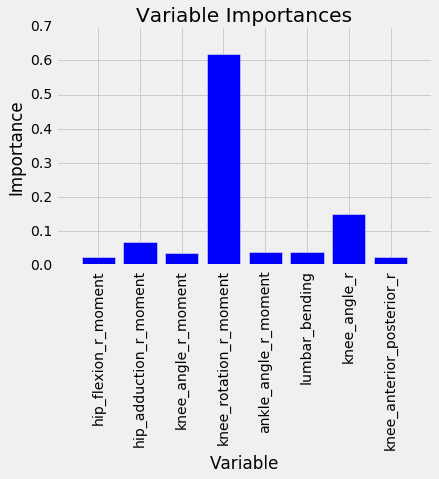

In [366]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical',align="center")
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

## Permutation importances tools - rfpimp

In [367]:
y = df['acl_r']
X = df.drop(['acl_r'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [368]:
rf = RandomForestRegressor(n_estimators = 1000,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_test, y_test)))

R^2 Training Score: 0.98 
OOB Score: 0.85 
R^2 Validation Score: 0.85


In [369]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)

In [454]:
perm_imp_rfpimp.Importance.loc[:,]
import_df.loc[:, (import_df != 0).all()]

Feature
knee_rotation_r_moment       0.810392
knee_angle_r                 0.084964
hip_adduction_r_moment       0.066937
KCF_X                        0.034683
knee_anterior_posterior_r    0.026121
hip_rotation_r               0.025933
knee_angle_r_moment          0.017508
lumbar_bending               0.011804
ankle_angle_r_moment         0.010006
KCF_Z                        0.009526
lumbar_extension             0.009507
hip_flexion_r                0.009020
subtalar_angle_r_moment      0.006953
lumbar_rotation              0.006306
hip_flexion_r_moment         0.003742
hip_rotation_r_moment        0.003455
knee_adduction_r_moment      0.003189
ankle_angle_r                0.003172
pelvis_list_moment           0.003030
KCF_Y                        0.002499
pelvis_tilt_moment           0.002071
hip_adduction_r              0.002024
pelvis_rotation_moment       0.001653
mtp_angle_r_moment           0.001503
Name: Importance, dtype: float64

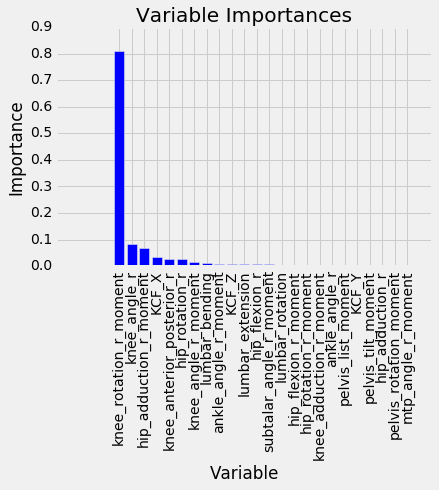

In [370]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(perm_imp_rfpimp)))
# Make a bar chart
plt.bar(x_values, perm_imp_rfpimp.Importance, orientation = 'vertical',align="center")
# Tick labels for x axis
plt.xticks(x_values, perm_imp_rfpimp.Importance.index, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

## Plot ensemble curve of acl forces as a function of knee angle ( as more intuitive since the movement occurs mainly in the saggittal plane)

In [413]:
"""First normalize and average between the trials"""
subjects = ['Ahelaos','Amanda','Celine','CharlotteH','CharlotteV','Esther','Filip',\
           'Franceska','Guido','Jeroen']
knee_angle_subj = []
acl_force_subj = []
for i in range(0,length):
    acl_r=[]
    array1=[]
    knee_angle=[]
    acl_force=[]
    name = subjects[i]
    results_dir = cwd+'/Data/'+name+'/Results'
    subj_dir = os.path.dirname(results_dir)
    kg = data.BodyWeight[i]
    kg_N = kg*9.81
    """ACL data"""
    for k in range(1,4):
        events_file = pd.read_excel(subj_dir+'/'+name+'_HDR_'+str(k)+'_Events.xls')
        init_time = events_file.InitialContactTime.iloc[0]
        final_time = events_file.TimeLowestCOMX.iloc[1]
        """Load kinematics"""
        ik_header, ik_labels, ik_data = readMotionFile(results_dir+'/HDR_'+str(k)+'_IK.mot')
        ik_d = np.array(ik_data)
        time = ik_d[:,0]
        timeList = time.tolist()
        idx3 = timeList.index(init_time)
        idx4 = timeList.index(final_time)
        array1 = ik_d[idx3:idx4+1,10]#knee angle
        array1 = array1.reshape(len(array1),1)
        # Interpolate the data using a quadratic spline to "new_length" samples
        new_length = 30
        x = np.array(range(0,len(array1)))
        y = abs(array1)
        new_x = np.linspace(0, len(array1)-1, new_length)
        new_knee_angle = sp.interpolate.interp1d(x, y, axis=0, kind='quadratic')(new_x)
        """Load the acl forces"""
        so_header, so_labels, so_data = readMotionFile(results_dir+'/'+name+'_2CL_HDR_'+str(k)+'_StaticOptimization_force.sto')
        idx1 = so_labels.index('aACL_R')
        idx2 = so_labels.index('pACL_R')
        aACL_R_data = np.array([row[idx1] for row in so_data])
        pACL_R_data = np.array([row[idx2] for row in so_data])
        acl_r = (aACL_R_data+pACL_R_data)/kg_N
        acl_r = acl_r.reshape(len(acl_r),1)
        # Interpolate the data using a quadratic spline to "new_length" samples
        new_length = 30
        x = np.array(range(0,len(acl_r)))
        y = abs(acl_r)
        new_x = np.linspace(0, len(array1)-1, new_length)
        new_acl_r = sp.interpolate.interp1d(x, y, axis=0, kind='quadratic')(new_x)    
        """Create the complete array for all three trials"""
        if k==1:
            knee_angle = new_knee_angle
            acl_force = new_acl_r
        else:
            knee_angle = np.concatenate((knee_angle,new_knee_angle),axis=1)
            acl_force = np.concatenate((acl_force,new_acl_r),axis=1)
    """Create the array for all subjects"""
    if i==0:
        knee_angle_subj = knee_angle
        acl_force_subj = acl_force
    else:
        knee_angle_subj = np.concatenate((knee_angle_subj,knee_angle),axis=1)
        acl_force_subj = np.concatenate((acl_force_subj,acl_force),axis=1)

In [414]:
Y = acl_force_subj.mean(axis=1)
X = knee_angle_subj.mean(axis=1)
Y_std = acl_force_subj.std(axis=1)
X_std = acl_force_subj.std(axis=1)

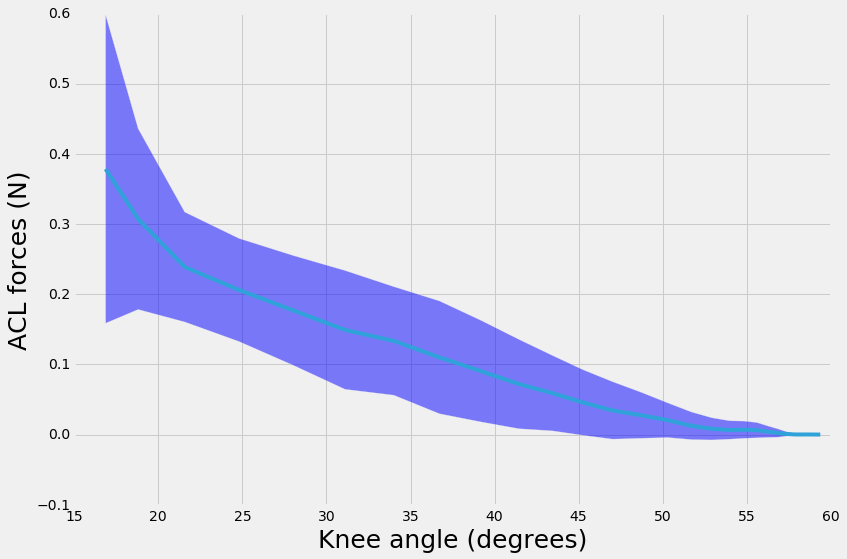

In [421]:
fig = plt.figure(figsize=(12, 8))
plt.plot(X,Y)
plt.fill_between(X,Y-Y_std,Y+Y_std,alpha=0.5)
plt.xlabel('Knee angle (degrees)',fontsize=25)
plt.ylabel('ACL forces (N)',fontsize=25)
plt.tight_layout()
fig.savefig('ACL forces - Knee angle.jpg', dpi=100)

In [383]:
fig.dpi

80.0